# 🕑 Répartition de timeline

# ▶ Run All  and take your ☕ then start from [15]
### 📌 Conclusion à la fin

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#df = pd.read_csv('NYC_311_Service_Requests_2023.csv')
df = pd.read_csv('NYC_311_Service_Requests_2023.csv',low_memory=False)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3225556 entries, 0 to 3225555
Data columns (total 41 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   Unique Key                      int64  
 1   Created Date                    object 
 2   Closed Date                     object 
 3   Agency                          object 
 4   Agency Name                     object 
 5   Complaint Type                  object 
 6   Descriptor                      object 
 7   Location Type                   object 
 8   Incident Zip                    object 
 9   Incident Address                object 
 10  Street Name                     object 
 11  Cross Street 1                  object 
 12  Cross Street 2                  object 
 13  Intersection Street 1           object 
 14  Intersection Street 2           object 
 15  Address Type                    object 
 16  City                            object 
 17  Landmark                   

In [2]:
df = pd.read_csv('NYC_311_Service_Requests_2023.csv',low_memory=False)

In [3]:
df.columns = df.columns.str.strip().str.replace(r'\s+', '_', regex=True).str.lower()
print (df.columns)

Index(['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
       'complaint_type', 'descriptor', 'location_type', 'incident_zip',
       'incident_address', 'street_name', 'cross_street_1', 'cross_street_2',
       'intersection_street_1', 'intersection_street_2', 'address_type',
       'city', 'landmark', 'facility_type', 'status', 'due_date',
       'resolution_description', 'resolution_action_updated_date',
       'community_board', 'bbl', 'borough', 'x_coordinate_(state_plane)',
       'y_coordinate_(state_plane)', 'open_data_channel_type',
       'park_facility_name', 'park_borough', 'vehicle_type',
       'taxi_company_borough', 'taxi_pick_up_location', 'bridge_highway_name',
       'bridge_highway_direction', 'road_ramp', 'bridge_highway_segment',
       'latitude', 'longitude', 'location'],
      dtype='object')


In [4]:
# Supprimer les espaces au début/fin
for col in df.select_dtypes(include=['object', 'string']).columns:
    df[col] = df[col].str.strip()

print("Espaces supprimés dans les colonnes textuelles du DataFrame.")

Espaces supprimés dans les colonnes textuelles du DataFrame.


In [5]:
# Convertir les colonnes en datetime en traitant les valeurs incorrectes comme NaT
df['created_date'] = pd.to_datetime(df['created_date'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
df['closed_date'] = pd.to_datetime(df['closed_date'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
df['resolution_action_updated_date'] = pd.to_datetime(df['resolution_action_updated_date'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')

# Calculer la différence de temps en heures entre 'closed_date' et 'created_date'
df['resolution_time_hours'] = (df['closed_date'] - df['created_date']).dt.total_seconds() / 3600

# Afficher le résultat
print(df[['created_date', 'closed_date', 'resolution_action_updated_date', 'resolution_time_hours']])

               created_date         closed_date  \
0       2023-12-31 23:59:42 2024-01-01 01:51:01   
1       2023-12-31 23:59:39 2024-01-19 14:37:37   
2       2023-12-31 23:59:29 2024-01-01 04:06:24   
3       2023-12-31 23:59:29 2024-01-01 01:51:32   
4       2023-12-31 23:59:23 2024-01-01 00:13:30   
...                     ...                 ...   
3225551 2023-01-01 00:00:46 2023-01-01 01:01:43   
3225552 2023-01-01 00:00:45 2023-01-01 01:24:10   
3225553 2023-01-01 00:00:42 2023-01-01 17:34:15   
3225554 2023-01-01 00:00:09 2023-01-01 00:36:06   
3225555 2023-01-01 00:00:00 2023-01-03 14:56:48   

        resolution_action_updated_date  resolution_time_hours  
0                  2024-01-01 01:51:05               1.855278  
1                  2024-01-19 14:37:41             446.632778  
2                  2024-01-01 04:06:28               4.115278  
3                  2024-01-01 01:51:35               1.867500  
4                  2024-01-01 00:13:33               0.235278  
...

In [6]:
# Calcul de la différence de temps entre les deux colonnes
df['time_diff'] = (df['resolution_action_updated_date'] - df['closed_date']).dt.total_seconds()

# Fonction de catégorisation des différences de temps et des NaN
def categorize_diff(row):
    # Cas où les deux dates sont manquantes
    if pd.isna(row['closed_date']) and pd.isna(row['resolution_action_updated_date']):
        return 'nan_updated+closed_date'
    
    # Cas où seule la closed_date est manquante
    elif pd.isna(row['closed_date']) and not pd.isna(row['resolution_action_updated_date']):
        return 'nan_closed'
    
    # Cas où seule la resolution_action_updated_date est manquante
    elif pd.isna(row['resolution_action_updated_date']) and not pd.isna(row['closed_date']):
        return 'nan_updated_date'
    
    # Si les deux dates sont présentes, on calcule la différence
    else:
        diff_seconds = row['time_diff']
        
        # Catégorisation basée sur la différence de temps
        if 0 <= diff_seconds <= 60:
            return '0-1m'
        elif 60 < diff_seconds <= 600:
            return '1m-10m'
        elif 600 < diff_seconds <= 3600:
            return '10m-1h'
        elif 3600 < diff_seconds <= 86400:
            return '1h-24h'
        elif 86400 < diff_seconds <= 604800:
            return '1j-7j'
        elif diff_seconds > 604800:
            return '7j+'
        else:
            return 'other'  # Cas général si la différence ne correspond à aucun intervalle

# Appliquer la fonction pour catégoriser chaque ligne
df['category'] = df.apply(categorize_diff, axis=1)

# Afficher le résultat final
print(df[['closed_date', 'resolution_action_updated_date', 'category']])

                closed_date resolution_action_updated_date category
0       2024-01-01 01:51:01            2024-01-01 01:51:05     0-1m
1       2024-01-19 14:37:37            2024-01-19 14:37:41     0-1m
2       2024-01-01 04:06:24            2024-01-01 04:06:28     0-1m
3       2024-01-01 01:51:32            2024-01-01 01:51:35     0-1m
4       2024-01-01 00:13:30            2024-01-01 00:13:33     0-1m
...                     ...                            ...      ...
3225551 2023-01-01 01:01:43            2023-01-01 01:01:49     0-1m
3225552 2023-01-01 01:24:10            2023-01-01 01:24:16     0-1m
3225553 2023-01-01 17:34:15            2023-01-01 17:34:20     0-1m
3225554 2023-01-01 00:36:06            2023-01-01 00:36:10     0-1m
3225555 2023-01-03 14:56:48            2023-01-03 14:56:43    other

[3225556 rows x 3 columns]


Comptage des catégories :
category
0-1m                       2217952
other                       870234
nan_closed                   61381
nan_updated+closed_date      27374
1h-24h                       26533
7j+                           9637
1j-7j                         7473
10m-1h                        3132
1m-10m                        1176
nan_updated_date               664
Name: count, dtype: int64


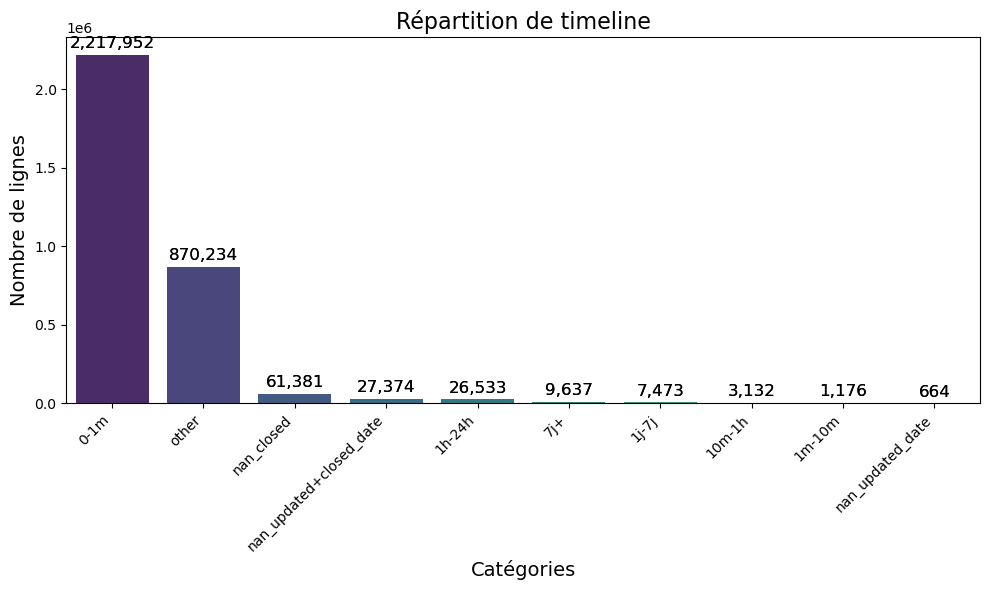

In [7]:
# Calculer le comptage des différentes catégories
category_counts = df['category'].value_counts()

# Afficher les résultats sous forme de tableau
print("Comptage des catégories :")
print(category_counts)

# Créer un graphique à barres pour visualiser la répartition des catégories
plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis", hue=category_counts.index, legend=False)
ax = sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis", hue=category_counts.index)


# Ajouter des labels et un titre
plt.title("Répartition de timeline", fontsize=16)
plt.xlabel("Catégories", fontsize=14)
plt.ylabel("Nombre de lignes", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()  # Ajuster le layout pour que tout soit bien visible

# Ajouter les chiffres sur les barres
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=12, color='black', 
                xytext=(0, 8), textcoords='offset points')

plt.tight_layout()  # Ajuster le layout pour que tout soit bien visible

# Afficher le graphique
plt.show()

In [8]:
# Fonction mise à jour pour catégoriser les différences de temps, y compris les délais négatifs
def categorize_diff(row):
    if pd.isna(row['closed_date']) and pd.isna(row['resolution_action_updated_date']):
        return 'nan_updated+closed_date'
    elif pd.isna(row['closed_date']):
        return 'nan_closed'
    elif pd.isna(row['resolution_action_updated_date']):
        return 'nan_updated_date'
    else:
        # Calcul de la différence de temps en secondes
        diff_seconds = (row['resolution_action_updated_date'] - row['closed_date']).total_seconds()

        # Cas pour les délais positifs
        if 0 <= diff_seconds <= 60:
            return '0-1m'
        elif 60 < diff_seconds <= 600:
            return '1m-10m'
        elif 600 < diff_seconds <= 3600:
            return '10m-1h'
        elif 3600 < diff_seconds <= 86400:
            return '1h-24h'
        elif 86400 < diff_seconds <= 604800:
            return '1j-7j'
        elif diff_seconds > 604800:
            return '7j+'
        
        # Cas pour les délais négatifs
        elif -10 <= diff_seconds < 0:
            return '-0-1m'
        elif -3600 <= diff_seconds < -10:
            return '-10s-1h'
        elif -86400 <= diff_seconds < -3600:
            return '-1h-24h'
        elif -604800 <= diff_seconds < -86400:
            return '-1j-7j'
        else:
            return '-7j-other'  # Si la différence est inférieure à -7 jours

# Appliquer la fonction pour catégoriser
df['category'] = df.apply(categorize_diff, axis=1)

# Afficher les résultats sous forme de tableau
print("Comptage des catégories :")
print(df['category'].value_counts())

Comptage des catégories :
category
0-1m                       2217952
-1h-24h                     751738
-1j-7j                       61692
nan_closed                   61381
-7j-other                    28796
nan_updated+closed_date      27374
1h-24h                       26533
-10s-1h                      15563
-0-1m                        12445
7j+                           9637
1j-7j                         7473
10m-1h                        3132
1m-10m                        1176
nan_updated_date               664
Name: count, dtype: int64


### ⬇️ Diff entre closed_date et resolution_action_updated_date

Comptage des catégories :
category
0-1m                       2217952
-1h-24h                     751738
-1j-7j                       61692
nan_closed                   61381
-7j-other                    28796
nan_updated+closed_date      27374
1h-24h                       26533
-10s-1h                      15563
-0-1m                        12445
7j+                           9637
1j-7j                         7473
10m-1h                        3132
1m-10m                        1176
nan_updated_date               664
other                            0
Name: count, dtype: int64


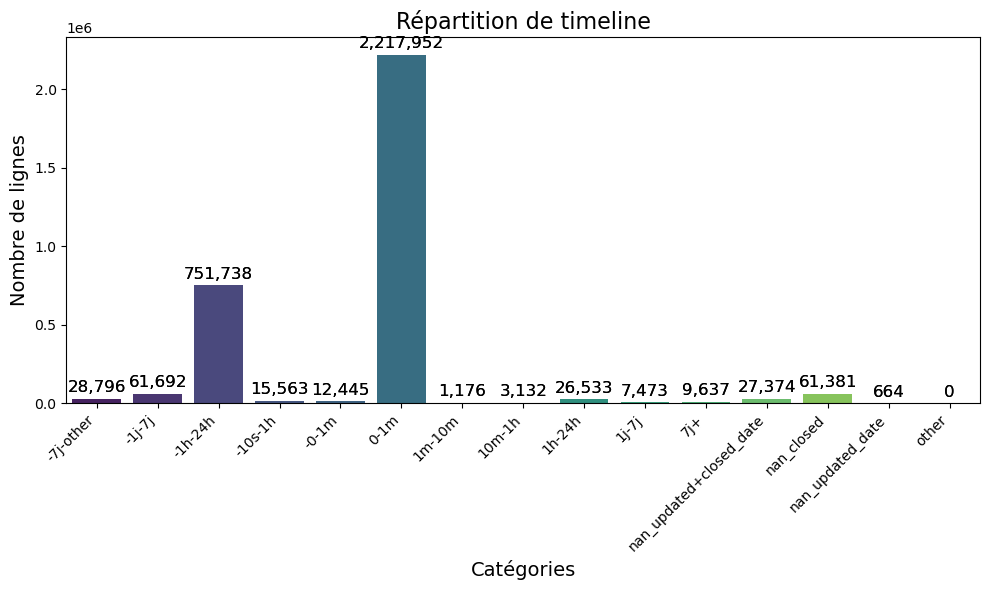

In [9]:
# Définir l'ordre des catégories de manière chronologique, d'abord les négatifs, puis les positifs, puis les NaN et autres
category_order = [
    '-7j-other', '-1j-7j', '-1h-24h', '-10s-1h', '-0-1m',  # Catégories négatives
    '0-1m', '1m-10m', '10m-1h', '1h-24h', '1j-7j', '7j+',     # Catégories positives
    'nan_updated+closed_date', 'nan_closed', 'nan_updated_date', 'other'  # Cas NaN et other
]

# Appliquer pd.Categorical pour organiser les catégories dans l'ordre spécifié
df['category'] = pd.Categorical(df['category'], categories=category_order, ordered=True)

# Calculer le comptage des différentes catégories
category_counts = df['category'].value_counts()

# Afficher les résultats sous forme de tableau
print("Comptage des catégories :")
print(category_counts)

# Créer un graphique à barres pour visualiser la répartition des catégories
plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis", hue=category_counts.index, legend=False)
ax = sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis", hue=category_counts.index)

# Ajouter des labels et un titre
plt.title("Répartition de timeline", fontsize=16)
plt.xlabel("Catégories", fontsize=14)
plt.ylabel("Nombre de lignes", fontsize=14)
plt.xticks(rotation=45, ha="right")

# Ajouter les chiffres sur les barres
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=12, color='black', 
                xytext=(0, 8), textcoords='offset points')

plt.tight_layout()  # Ajuster le layout pour que tout soit bien visible

# Afficher le graphique
plt.show()

In [10]:
# Trouver la valeur maximale positive et la ligne correspondante
#max_positive = df['time_diff'].max()
#max_positive_row = df[df['time_diff'] == max_positive]

# Trouver la deuxième valeur minimale négative et la ligne correspondante
#second_min_negative = df['time_diff'].nsmallest(2).iloc[-1] if len(df[df['time_diff'] < 0]) >= 2 else None
#second_min_negative_row = df[df['time_diff'] == second_min_negative]

# Afficher les résultats complets pour les lignes correspondantes
#print(f"Valeur maximale positive : {max_positive} secondes")
#print(f"Ligne correspondante à la valeur maximale positive :")
#print(max_positive_row.to_string(index=False))  # Affiche la ligne complète sans l'index

#print(f"\nDeuxième valeur minimale négative : {second_min_negative} secondes")
#print(f"Ligne correspondante à la deuxième valeur minimale négative :")
#print(second_min_negative_row.to_string(index=False))  # Affiche la ligne complète sans l'index

In [11]:
# Trouver le délai le plus long positif
max_time = df["resolution_time_hours"].max()

# Trouver le délai le plus négatif
min_time = df["resolution_time_hours"].min()

# Fonction pour convertir des heures en jours, heures, minutes, secondes
def convert_hours_to_dhms(hours):
    total_seconds = int(hours * 3600)
    days = total_seconds // 86400
    hours = (total_seconds % 86400) // 3600
    minutes = (total_seconds % 3600) // 60
    seconds = total_seconds % 60
    return f"{days}j {hours}h {minutes}m {seconds}s"

# Conversion
delai_plus_long = convert_hours_to_dhms(max_time)
delai_plus_negatif = convert_hours_to_dhms(min_time)

# Affichage
print(f"Délai le plus long positif (+) : {delai_plus_long}")
print(f"Délai le plus négatif (-) : {delai_plus_negatif}")

Délai le plus long positif (+) : 706j 0h 1m 34s
Délai le plus négatif (-) : -378j 0h 0m 0s



⏱️ "resolution_time_hours" Délai positif : 706j 0h 1m 34s (1 017 841,57 minutes)  et Délai négatif : -378j 0h 0m 0s (-544 320 minutes)

In [12]:
print(f"Total NaN dans 'resolution_action_updated_date' : {df['resolution_action_updated_date'].isna().sum()}")
print(f"Total NaN dans 'closed_date' : {df['closed_date'].isna().sum()}")

Total NaN dans 'resolution_action_updated_date' : 28038
Total NaN dans 'closed_date' : 88755


In [13]:
print(f"Total dans 'nan_updated_date' : {df[df['category'] == 'nan_updated_date'].shape[0]}")
print(f"Total dans 'nan_updated+closed_date' : {df[df['category'] == 'nan_updated+closed_date'].shape[0]}")

Total dans 'nan_updated_date' : 664
Total dans 'nan_updated+closed_date' : 27374


In [14]:
null_counts = df.isnull().sum()
print(null_counts)

unique_key                              0
created_date                            0
closed_date                         88755
agency                                  0
agency_name                             0
complaint_type                          0
descriptor                          97868
location_type                      384752
incident_zip                        38561
incident_address                   123642
street_name                        123723
cross_street_1                     917651
cross_street_2                     916754
intersection_street_1             1050482
intersection_street_2             1048666
address_type                        16275
city                               163916
landmark                          1283630
facility_type                     3208928
status                                  0
due_date                          3213081
resolution_description              67837
resolution_action_updated_date      28038
community_board                   

# Start is here 👇

In [15]:
# Filtrer les lignes où time_diff est négatif
df_negtimediff = df[df['time_diff'] < 0]

# Afficher le nombre de cas problématiques
print(f"Nombre de lignes avec time_diff négatif : {len(df_negtimediff)}")

Nombre de lignes avec time_diff négatif : 870234


In [16]:
# Filtrer les lignes où resolution_time_hours est négatif
df_negatifs = df[df['resolution_time_hours'] < 0]

# Afficher le nombre de cas problématiques
print(f"Nombre de lignes avec resolution_time_hours négatif : {len(df_negatifs)}")

Nombre de lignes avec resolution_time_hours négatif : 4307


In [17]:
# Calculer la différence de temps en heures entre 'resolution_action_updated_date' et 'created_date'
df['diff_updcrea_hours'] = (df['resolution_action_updated_date'] - df['created_date']).dt.total_seconds() / 3600

# Filtrer les valeurs négatives
df_negupdcrea = df[df['diff_updcrea_hours'] < 0]

# Afficher le nombre de valeurs négatives
print(f"Nombre de lignes avec une différence négative : {len(df_negupdcrea)}")

Nombre de lignes avec une différence négative : 73628


# Valeurs manquant dans closed_date

In [18]:
# 1. Filtrer les lignes où 'closed_date' est NaN
missing_closed_date = df[df['closed_date'].isna()]

# 2. Compter les occurrences des différents 'status' parmi les lignes manquantes
status_counts = missing_closed_date['status'].value_counts()

# 3. Calculer les pourcentages
status_percentages = (status_counts / len(missing_closed_date)) * 100

# 4. Afficher les résultats
print("Pourcentage des lignes avec 'closed_date' manquante par statut :")
print(status_percentages)

Pourcentage des lignes avec 'closed_date' manquante par statut :
status
In Progress    71.083319
Closed         22.818996
Open            2.791955
Assigned        1.345276
Pending         1.151484
Started         0.753760
Unspecified     0.055208
Name: count, dtype: float64


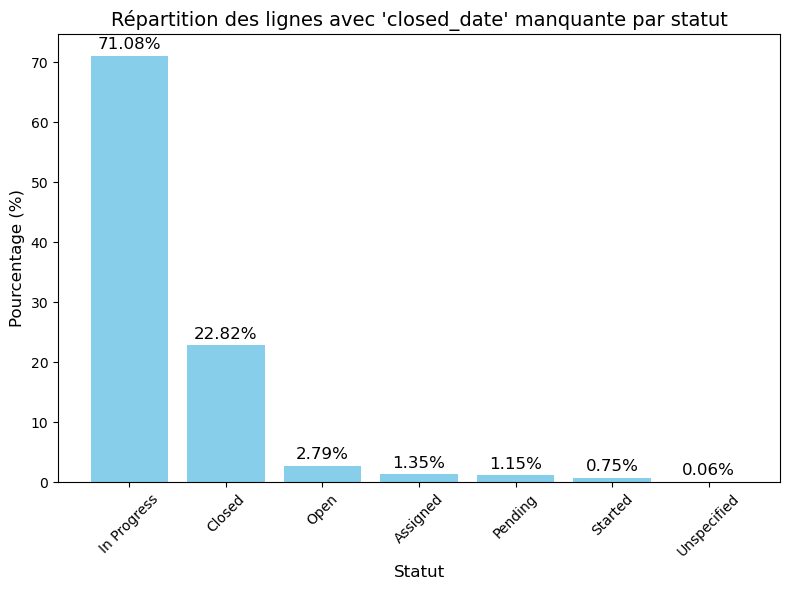

In [49]:
# 4. Créer un graphe simple
plt.figure(figsize=(8, 6))
ax = plt.gca()  # Obtenir l'objet des axes

bars = ax.bar(status_percentages.index, status_percentages.values, color='skyblue')

# Ajouter un titre et des labels
plt.title("Répartition des lignes avec 'closed_date' manquante par statut", fontsize=14)
plt.xlabel("Statut", fontsize=12)
plt.ylabel("Pourcentage (%)", fontsize=12)

# Rotation des labels de l'axe x
plt.xticks(rotation=45, fontsize=10)

# Ajouter les chiffres sur les barres
for p in bars:
    ax.annotate(f'{p.get_height():,.2f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=12, color='black', 
                xytext=(0, 8), textcoords='offset points')

# Afficher le graphe
plt.tight_layout()
plt.show()

# 🎶 Conclusion :
En comparant les trois colonnes created_date, resolution_action_updated_date et closed_date, voici les résultats obtenus :

Entre closed_date et created_date, nous avons :
➖ 4307 dates négatives.
❕ 88 755 dates manquantes.

Entre resolution_action_updated_date et closed_date, nous constatons :
➖ 870 234 dates négatives.
❕ 28 038 dates manquantes.

Enfin, en comparant resolution_action_updated_date avec created_date, nous relevons :
➖ 73 628 dates négatives.

Pour 88 755 dates manquantes de closed_date est 94% en status "In progres" et "Closed". Dans le nouveau DataSet téléchargé le 12 janvier 2025, il y a  85 475 rows manquées au lieu de 88 755 (au cours des 4 dernières semaines). Cela signifie que cette colonne se remplit progressivement par cloced dates. Plus de 3 000 dates supplémentaires ont été remplies.

### ⬇️ Diff entre closed_date et created_date

In [51]:
# Calculer la différence en minutes entre 'closed_date' et 'created_date'
df['diff_clcrea_minutes'] = (df['closed_date'] - df['created_date']).dt.total_seconds() / 60  # Convertir en minutes

# Identifier les lignes avec 'closed_date' manquant
null_closed_date = df[df['closed_date'].isnull()]

# Création d'une nouvelle colonne de catégories avec une valeur par défaut
df['category_clcrea'] = 'other'  # Valeur par défaut

# Afficher le nombre de lignes où 'closed_date' est manquant
print(f"\nNombre de lignes avec 'closed_date' manquant : {len(null_closed_date)}")

# **Catégorisation détaillée des valeurs négatives**
df.loc[df['diff_clcrea_minutes'].isnull(), 'category_clcrea'] = 'null_closed_date'  # Cas où la valeur est NaN
df.loc[df['diff_clcrea_minutes'] < -7 * 24 * 60, 'category_clcrea'] = '-7j-other'  # Moins de -7 jours
df.loc[(df['diff_clcrea_minutes'] >= -7 * 24 * 60) & (df['diff_clcrea_minutes'] < -1 * 24 * 60), 'category_clcrea'] = '-1j-7j'  # Entre -7 jours et -1 jour
df.loc[(df['diff_clcrea_minutes'] >= -1 * 24 * 60) & (df['diff_clcrea_minutes'] < -60), 'category_clcrea'] = '-1h-24h'  # Entre -1 jour et -1 heure
df.loc[(df['diff_clcrea_minutes'] >= -60) & (df['diff_clcrea_minutes'] < -10), 'category_clcrea'] = '-10m-1h'  # Entre -1 heure et -10 minutes
df.loc[(df['diff_clcrea_minutes'] >= -10) & (df['diff_clcrea_minutes'] < 0), 'category_clcrea'] = '-0-10m'  # Entre -10 minutes et maintenant

# **Catégorisation des valeurs positives pour 0-1m, 1m-10m, 10m-1h**
df.loc[(df['diff_clcrea_minutes'] >= 0) & (df['diff_clcrea_minutes'] < 1), 'category_clcrea'] = '0-1m'
df.loc[(df['diff_clcrea_minutes'] >= 1) & (df['diff_clcrea_minutes'] < 10), 'category_clcrea'] = '1m-10m'
df.loc[(df['diff_clcrea_minutes'] >= 10) & (df['diff_clcrea_minutes'] < 60), 'category_clcrea'] = '10m-1h'

# **Catégorisation des autres valeurs**
df.loc[(df['diff_clcrea_minutes'] >= 60) & (df['diff_clcrea_minutes'] < 1440), 'category_clcrea'] = '1h-24h'
df.loc[(df['diff_clcrea_minutes'] >= 1440) & (df['diff_clcrea_minutes'] < 2880), 'category_clcrea'] = '24h-48h'
df.loc[(df['diff_clcrea_minutes'] >= 2880) & (df['diff_clcrea_minutes'] < 10080), 'category_clcrea'] = '2j-7j'
df.loc[df['diff_clcrea_minutes'] >= 10080, 'category_clcrea'] = '7j+'

# Définir l'ordre des catégories
category_order = [
    '-7j-other', '-1j-7j', '-1h-24h', '-10m-1h', '-0-10m',  # Catégories négatives
    '0-1m', '1m-10m', '10m-1h', '1h-24h', '24h-48h', '2j-7j', '7j+',  # Catégories positives
    'null_closed_date', 'other'  # Cas où closed_date est manquant
]

# Appliquer pd.Categorical pour organiser les catégories dans l'ordre spécifié
df['category_clcrea'] = pd.Categorical(df['category_clcrea'], categories=category_order, ordered=True)

# Calculer le comptage des différentes catégories
category_counts = df['category_clcrea'].value_counts()

# Afficher les résultats sous forme de tableau
print("\nComptage des catégories :")
print(category_counts)

# Afficher des statistiques sur 'diff_clcrea_minutes'
print("\nStatistiques sur la durée de résolution :")
print(df['diff_clcrea_minutes'].describe())


Nombre de lignes avec 'closed_date' manquant : 88755

Comptage des catégories :
category_clcrea
1h-24h              931729
10m-1h              730504
7j+                 617345
2j-7j               421688
24h-48h             236050
1m-10m              125042
null_closed_date     88755
0-1m                 70136
-1j-7j                3436
-7j-other              383
-1h-24h                333
-10m-1h                128
-0-10m                  27
other                    0
Name: count, dtype: int64

Statistiques sur la durée de résolution :
count    3.136801e+06
mean     2.037096e+04
std      7.832873e+04
min     -5.443200e+05
25%      4.493333e+01
50%      4.359667e+02
75%      5.757000e+03
max      1.016642e+06
Name: diff_clcrea_minutes, dtype: float64


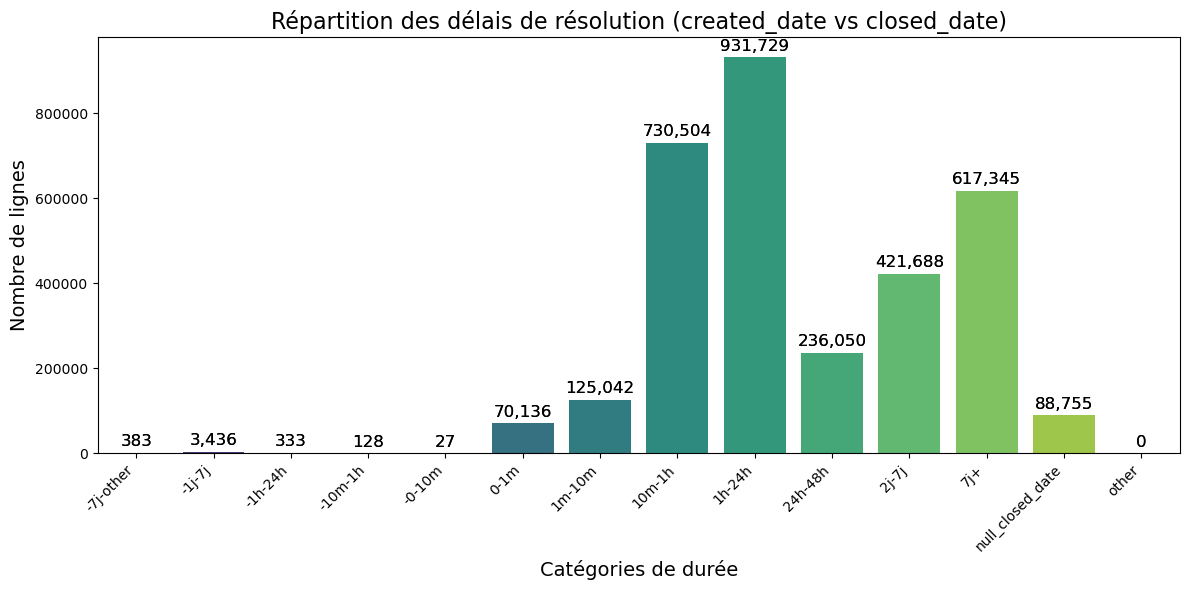

In [52]:
# Vérifier si des données sont disponibles pour le graphique
if category_counts.empty:
    print("Aucune donnée disponible pour l'affichage du graphique.")
else:
    # **Affichage du graphique avec deux lignes sns.barplot**
    plt.figure(figsize=(12, 6))
    
    sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis", hue=category_counts.index, legend=False)
    ax = sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis", hue=category_counts.index)

    # Ajouter des labels et un titre
    plt.title("Répartition des délais de résolution (created_date vs closed_date)", fontsize=16)
    plt.xlabel("Catégories de durée", fontsize=14)
    plt.ylabel("Nombre de lignes", fontsize=14)
    plt.xticks(rotation=45, ha="right")

    # Ajouter les chiffres sur les barres
    for p in ax.patches:
        ax.annotate(f'{p.get_height():,.0f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    fontsize=12, color='black', 
                    xytext=(0, 8), textcoords='offset points')

    plt.tight_layout()  # Ajuster le layout pour que tout soit bien visible
    plt.show()

Les plaintes de type '0-1m'

In [22]:
# Paramétrer Pandas pour ne pas tronquer les valeurs des colonnes longues
pd.set_option('display.max_colwidth', None)

# Filtrer les données pour les plaintes de type '0-1m'
filtered_complaints = df[df['category_clcrea'] == '0-1m']

# Regrouper par les colonnes 'descriptor', 'complaint_type', 'resolution_description' et compter les occurrences
top_20_complaints = filtered_complaints.groupby(['descriptor', 'complaint_type', 'resolution_description']).size().reset_index(name='count')

# Trier par le nombre d'occurrences (en ordre décroissant) et sélectionner les 20 premiers
top_20_complaints = top_20_complaints.sort_values(by='count', ascending=False).head(20)

# Créer un tableau clair avec les colonnes 'descriptor', 'complaint_type', 'resolution_description'
table = top_20_complaints[['descriptor', 'complaint_type', 'resolution_description', 'count']]

from IPython.display import display
display(table)

,descriptor,complaint_type,resolution_description,count
928,Rat Sighting,Rodent,The Department of Health and Mental Hygiene found violations on the property you reported. Follow-up inspections will be scheduled.,7353
929,Rat Sighting,Rodent,The Department of Health and Mental Hygiene inspected the property you reported and did not find any violations at the time of the inspection. The property passed inspection.,6648
1046,Street Light Out,Street Light Condition,Service Request status for this request is available on the Department of Transportationâs website. Please click the âLearn Moreâ link below.,4678
891,Pothole,Street Condition,The Department of Transportation determined that this complaint is a duplicate of a previously filed complaint. The original complaint is being addressed.,3968
1162,Work Without A Permit - Occupied Multiple Dwelling,Real Time Enforcement,The Department of Buildings investigated this complaint and determined that no further action was necessary.,2294
244,Condition Attracting Rodents,Rodent,The Department of Health and Mental Hygiene found violations on the property you reported. Follow-up inspections will be scheduled.,2240
245,Condition Attracting Rodents,Rodent,The Department of Health and Mental Hygiene inspected the property you reported and did not find any violations at the time of the inspection. The property passed inspection.,1950
473,Fire Hydrant Emergency (FHE),Water System,The Department of Environmental Protection investigated this complaint and shut the running hydrant.,1603
1007,Signs of Rodents,Rodent,The Department of Health and Mental Hygiene inspected the property you reported and did not find any violations at the time of the inspection. The property passed inspection.,1190
545,Hydrant Running Full (WA4),Water System,The Department of Environmental Protection determined that this complaint is a duplicate of a previously filed complaint. The original complaint is being addressed.,1139


Conclusion : Top 20 de "0s-1m" sur rodent, Unleashed Dog, Unsanitary Animal, Hydrant, Street Light Out, Boilers...

In [23]:
# Regrouper par 'descriptor', 'complaint_type', 'resolution_description' et compter les occurrences
top_20_agencies = filtered_complaints.groupby(['agency_name']).size().reset_index(name='count')

# Trier par le nombre d'occurrences (en ordre décroissant) et sélectionner les 20 premiers
top_20_agencies = top_20_agencies.sort_values(by='count', ascending=False).head(20)

# Créer un tableau clair avec les colonnes 'agency_name' et 'count'
table_agencies = top_20_agencies[['agency_name', 'count']]

# Afficher le tableau des top 20 agences
print(table_agencies)

                                          agency_name  count
2             Department of Health and Mental Hygiene  31264
0                             Department of Buildings  13087
7                        Department of Transportation  12354
8                     New York City Police Department   6389
1              Department of Environmental Protection   5841
4  Department of Housing Preservation and Development    891
5                  Department of Parks and Recreation    219
6                            Department of Sanitation     55
9                       Taxi and Limousine Commission     19
3                     Department of Homeless Services     17


Conclusion : Top 20 de "0s-1m" sur Department of Health and Mental Hygiene,  Department of Buildings  , Department of Transportation , New York City Police Department   6389
et  Department of Environmental Protection.

'1m-10m'

In [24]:
# Paramétrer Pandas pour ne pas tronquer les valeurs des colonnes longues
pd.set_option('display.max_colwidth', None)

# Filtrer les données pour les plaintes de type '1m-10m'
filtered_complaints = df[df['category_clcrea'] == '1m-10m']

# Regrouper par les colonnes 'descriptor', 'complaint_type', 'resolution_description' et compter les occurrences
top_20_complaints = filtered_complaints.groupby(['descriptor', 'complaint_type', 'resolution_description']).size().reset_index(name='count')

# Trier par le nombre d'occurrences (en ordre décroissant) et sélectionner les 20 premiers
top_20_complaints = top_20_complaints.sort_values(by='count', ascending=False).head(20)

# Créer un tableau clair avec les colonnes 'descriptor', 'complaint_type', 'resolution_description'
table = top_20_complaints[['descriptor', 'complaint_type', 'resolution_description', 'count']]

from IPython.display import display
display(table)

,descriptor,complaint_type,resolution_description,count
544,Loud Music/Party,Noise - Street/Sidewalk,The Police Department responded to the complaint and took action to fix the condition.,6663
532,Loud Music/Party,Noise - Residential,The Police Department responded to the complaint and took action to fix the condition.,6481
1015,Use Outside,Drug Activity,The Police Department responded to the complaint and determined that police action was not necessary.,3825
533,Loud Music/Party,Noise - Residential,The Police Department responded to the complaint and with the information available observed no evidence of the violation at that time.,3705
506,Loud Music/Party,Noise - Commercial,The Police Department responded to the complaint and took action to fix the condition.,3623
55,Banging/Pounding,Noise - Residential,The Police Department responded to the complaint and determined that police action was not necessary.,3514
545,Loud Music/Party,Noise - Street/Sidewalk,The Police Department responded to the complaint and with the information available observed no evidence of the violation at that time.,3458
531,Loud Music/Party,Noise - Residential,The Police Department responded to the complaint and determined that police action was not necessary.,3075
57,Banging/Pounding,Noise - Residential,The Police Department responded to the complaint and with the information available observed no evidence of the violation at that time.,2887
543,Loud Music/Party,Noise - Street/Sidewalk,The Police Department responded to the complaint and determined that police action was not necessary.,2474


Conclusion : Top 20 de '1m-10m' sur Loud Music/Party	Noise, Drug Activity, Illegal Parking

In [25]:
# Regrouper par 'descriptor', 'complaint_type', 'resolution_description' et compter les occurrences
top_20_agencies = filtered_complaints.groupby(['agency_name']).size().reset_index(name='count')

# Trier par le nombre d'occurrences (en ordre décroissant) et sélectionner les 20 premiers
top_20_agencies = top_20_agencies.sort_values(by='count', ascending=False).head(20)

# Créer un tableau clair avec les colonnes 'agency_name' et 'count'
table_agencies = top_20_agencies[['agency_name', 'count']]

# Afficher le tableau des top 20 agences
print(table_agencies)

                                           agency_name   count
10                     New York City Police Department  114949
3               Department of Environmental Protection    4242
5                      Department of Homeless Services    2368
7                   Department of Parks and Recreation    1184
11                       Taxi and Limousine Commission    1015
9                         Department of Transportation     621
8                             Department of Sanitation     377
6   Department of Housing Preservation and Development     240
0                              Department of Buildings      40
2                              Department of Education       4
1         Department of Consumer and Worker Protection       1
4              Department of Health and Mental Hygiene       1


Top 20 de '10m-1h'

In [26]:
# Paramétrer Pandas pour ne pas tronquer les valeurs des colonnes longues
pd.set_option('display.max_colwidth', None)

# Filtrer les données pour les plaintes de type '10m-1h'
filtered_complaints = df[df['category_clcrea'] == '10m-1h']

# Regrouper par les colonnes 'descriptor', 'complaint_type', 'resolution_description' et compter les occurrences
top_20_complaints = filtered_complaints.groupby(['descriptor', 'complaint_type', 'resolution_description']).size().reset_index(name='count')

# Trier par le nombre d'occurrences (en ordre décroissant) et sélectionner les 20 premiers
top_20_complaints = top_20_complaints.sort_values(by='count', ascending=False).head(20)

# Créer un tableau clair avec les colonnes 'descriptor', 'complaint_type', 'resolution_description'
table = top_20_complaints[['descriptor', 'complaint_type', 'resolution_description', 'count']]

from IPython.display import display
display(table)

,descriptor,complaint_type,resolution_description,count
941,Loud Music/Party,Noise - Residential,The Police Department responded to the complaint and took action to fix the condition.,50016
953,Loud Music/Party,Noise - Street/Sidewalk,The Police Department responded to the complaint and took action to fix the condition.,36774
942,Loud Music/Party,Noise - Residential,The Police Department responded to the complaint and with the information available observed no evidence of the violation at that time.,30225
954,Loud Music/Party,Noise - Street/Sidewalk,The Police Department responded to the complaint and with the information available observed no evidence of the violation at that time.,23066
1086,No Access,Blocked Driveway,The Police Department issued a summons in response to the complaint.,18887
98,Banging/Pounding,Noise - Residential,The Police Department responded to the complaint and with the information available observed no evidence of the violation at that time.,18759
908,Loud Music/Party,Noise - Commercial,The Police Department responded to the complaint and took action to fix the condition.,18369
97,Banging/Pounding,Noise - Residential,The Police Department responded to the complaint and took action to fix the condition.,18251
154,Blocked Hydrant,Illegal Parking,The Police Department issued a summons in response to the complaint.,17233
1368,Posted Parking Sign Violation,Illegal Parking,The Police Department responded to the complaint and took action to fix the condition.,15539


Conclusion : Top 20 de '10m-1h' sur Noise, Blocked Driveway, Blocked Hydrant, Abandoned Vehicle, Illegal Parking	

In [27]:
# Regrouper par 'descriptor', 'complaint_type', 'resolution_description' et compter les occurrences
top_20_agencies = filtered_complaints.groupby(['agency_name']).size().reset_index(name='count')

# Trier par le nombre d'occurrences (en ordre décroissant) et sélectionner les 20 premiers
top_20_agencies = top_20_agencies.sort_values(by='count', ascending=False).head(20)

# Créer un tableau clair avec les colonnes 'agency_name' et 'count'
table_agencies = top_20_agencies[['agency_name', 'count']]

# Afficher le tableau des top 20 agences
print(table_agencies)

                                           agency_name   count
10                     New York City Police Department  696921
3               Department of Environmental Protection   12908
9                         Department of Transportation    7557
7                   Department of Parks and Recreation    3884
5                      Department of Homeless Services    3488
8                             Department of Sanitation    2025
6   Department of Housing Preservation and Development    1482
11                       Taxi and Limousine Commission    1188
4              Department of Health and Mental Hygiene     759
0                              Department of Buildings     258
2                              Department of Education      31
1         Department of Consumer and Worker Protection       3


Top 20 de '1h-24h'

In [28]:
# Paramétrer Pandas pour ne pas tronquer les valeurs des colonnes longues
pd.set_option('display.max_colwidth', None)

# Filtrer les données pour les plaintes de type '1h-24h'
filtered_complaints = df[df['category_clcrea'] == '1h-24h']

# Regrouper par les colonnes 'descriptor', 'complaint_type', 'resolution_description' et compter les occurrences
top_20_complaints = filtered_complaints.groupby(['descriptor', 'complaint_type', 'resolution_description']).size().reset_index(name='count')

# Trier par le nombre d'occurrences (en ordre décroissant) et sélectionner les 20 premiers
top_20_complaints = top_20_complaints.sort_values(by='count', ascending=False).head(20)

# Créer un tableau clair avec les colonnes 'descriptor', 'complaint_type', 'resolution_description'
table = top_20_complaints[['descriptor', 'complaint_type', 'resolution_description', 'count']]

from IPython.display import display
display(table)

,descriptor,complaint_type,resolution_description,count
2489,Loud Music/Party,Noise - Residential,The Police Department responded to the complaint and with the information available observed no evidence of the violation at that time.,26574
337,Blocked Hydrant,Illegal Parking,The Police Department responded and upon arrival those responsible for the condition were gone.,25204
2735,No Access,Blocked Driveway,The Police Department responded and upon arrival those responsible for the condition were gone.,24923
335,Blocked Hydrant,Illegal Parking,The Police Department issued a summons in response to the complaint.,18588
2733,No Access,Blocked Driveway,The Police Department issued a summons in response to the complaint.,17657
2488,Loud Music/Party,Noise - Residential,The Police Department responded to the complaint and took action to fix the condition.,17082
3385,Pothole,Street Condition,The Department of Transportation inspected this complaint and repaired the problem.,16054
2501,Loud Music/Party,Noise - Street/Sidewalk,The Police Department responded to the complaint and with the information available observed no evidence of the violation at that time.,14967
204,Banging/Pounding,Noise - Residential,The Police Department responded to the complaint and with the information available observed no evidence of the violation at that time.,14191
4878,With License Plate,Abandoned Vehicle,The Police Department responded to the complaint and took action to fix the condition.,13271


In [29]:
# Regrouper par 'descriptor', 'complaint_type', 'resolution_description' et compter les occurrences
top_20_agencies = filtered_complaints.groupby(['agency_name']).size().reset_index(name='count')

# Trier par le nombre d'occurrences (en ordre décroissant) et sélectionner les 20 premiers
top_20_agencies = top_20_agencies.sort_values(by='count', ascending=False).head(20)

# Créer un tableau clair avec les colonnes 'agency_name' et 'count'
table_agencies = top_20_agencies[['agency_name', 'count']]

# Afficher le tableau des top 20 agences
print(table_agencies)

                                           agency_name   count
10                     New York City Police Department  570794
8                             Department of Sanitation   91040
6   Department of Housing Preservation and Development   81383
3               Department of Environmental Protection   67955
9                         Department of Transportation   60428
7                   Department of Parks and Recreation   13897
5                      Department of Homeless Services   13539
0                              Department of Buildings   12960
4              Department of Health and Mental Hygiene   11590
1         Department of Consumer and Worker Protection    6514
12                       Taxi and Limousine Commission    1329
2                              Department of Education     291
11                 Office of Technology and Innovation       9


Top 20 de '24h-48h'

In [30]:
# Paramétrer Pandas pour ne pas tronquer les valeurs des colonnes longues
pd.set_option('display.max_colwidth', None)

# Filtrer les données pour les plaintes de type '24h-48h'
filtered_complaints = df[df['category_clcrea'] == '24h-48h']

# Regrouper par les colonnes 'descriptor', 'complaint_type', 'resolution_description' et compter les occurrences
top_20_complaints = filtered_complaints.groupby(['descriptor', 'complaint_type', 'resolution_description']).size().reset_index(name='count')

# Trier par le nombre d'occurrences (en ordre décroissant) et sélectionner les 20 premiers
top_20_complaints = top_20_complaints.sort_values(by='count', ascending=False).head(20)

# Créer un tableau clair avec les colonnes 'descriptor', 'complaint_type', 'resolution_description'
table = top_20_complaints[['descriptor', 'complaint_type', 'resolution_description', 'count']]

from IPython.display import display
display(table)

,descriptor,complaint_type,resolution_description,count
1178,ENTIRE BUILDING,HEAT/HOT WATER,The complaint you filed is a duplicate of a condition already reported by another tenant for a building-wide condition. The original complaint is still open. HPD may attempt to contact you to verify the correction of the condition or may conduct an inspection of your unit if the original complainant is not available for verification.,19123
1173,ENTIRE BUILDING,HEAT/HOT WATER,"The Department of Housing Preservation and Development responded to a complaint of no heat or hot water and was advised by a tenant in the building that heat and hot water had been restored. If the condition still exists, please file a new complaint.",10167
34,APARTMENT ONLY,HEAT/HOT WATER,The complaint you filed is a duplicate of a condition already reported by another tenant for a building-wide condition. The original complaint is still open. HPD may attempt to contact you to verify the correction of the condition or may conduct an inspection of your unit if the original complainant is not available for verification.,7059
1167,ENTIRE BUILDING,HEAT/HOT WATER,"The Department of Housing Preservation and Development contacted a tenant in the building and verified that the following conditions were corrected. The complaint has been closed. If the condition still exists, please file a new complaint.",6645
1176,ENTIRE BUILDING,HEAT/HOT WATER,"The Department of Housing Preservation and Development was not able to gain access to your apartment or others in the building to inspect for a lack of heat or hot water. The complaint has been closed. If the condition still exists, please file a new complaint.",6346
32,APARTMENT ONLY,HEAT/HOT WATER,"The Department of Housing Preservation and Development was not able to gain access to your apartment or others in the building to inspect for a lack of heat or hot water. The complaint has been closed. If the condition still exists, please file a new complaint.",5895
2546,Pothole,Street Condition,The Department of Transportation inspected this complaint and repaired the problem.,5745
24,APARTMENT ONLY,HEAT/HOT WATER,"The Department of Housing Preservation and Development contacted an occupant of the apartment and verified that the following conditions were corrected. The complaint has been closed. If the condition still exists, please file a new complaint.",4800
3330,Trash,Dirty Condition,The Department of Sanitation investigated this complaint and found no condition at the location.,4199
1256,Ewaste appointment,Electronics Waste Appointment,The Department of Sanitation collected the E-waste.,4023


In [31]:
# Regrouper par 'descriptor', 'complaint_type', 'resolution_description' et compter les occurrences
top_20_agencies = filtered_complaints.groupby(['agency_name']).size().reset_index(name='count')

# Trier par le nombre d'occurrences (en ordre décroissant) et sélectionner les 20 premiers
top_20_agencies = top_20_agencies.sort_values(by='count', ascending=False).head(20)

# Créer un tableau clair avec les colonnes 'agency_name' et 'count'
table_agencies = top_20_agencies[['agency_name', 'count']]

# Afficher le tableau des top 20 agences
print(table_agencies)

                                           agency_name   count
6   Department of Housing Preservation and Development  109624
8                             Department of Sanitation   60806
3               Department of Environmental Protection   21202
9                         Department of Transportation   19583
0                              Department of Buildings    5750
7                   Department of Parks and Recreation    5526
4              Department of Health and Mental Hygiene    3770
1         Department of Consumer and Worker Protection    3729
10                     New York City Police Department    2987
5                      Department of Homeless Services    2062
12                       Taxi and Limousine Commission     916
2                              Department of Education      89
11                 Office of Technology and Innovation       6


Top 20 de '2j-7j'

In [32]:
# Paramétrer Pandas pour ne pas tronquer les valeurs des colonnes longues
pd.set_option('display.max_colwidth', None)

# Filtrer les données pour les plaintes de type '2j-7j'
filtered_complaints = df[df['category_clcrea'] == '2j-7j']

# Regrouper par les colonnes 'descriptor', 'complaint_type', 'resolution_description' et compter les occurrences
top_20_complaints = filtered_complaints.groupby(['descriptor', 'complaint_type', 'resolution_description']).size().reset_index(name='count')

# Trier par le nombre d'occurrences (en ordre décroissant) et sélectionner les 20 premiers
top_20_complaints = top_20_complaints.sort_values(by='count', ascending=False).head(20)

# Créer un tableau clair avec les colonnes 'descriptor', 'complaint_type', 'resolution_description'
table = top_20_complaints[['descriptor', 'complaint_type', 'resolution_description', 'count']]

from IPython.display import display
display(table)

,descriptor,complaint_type,resolution_description,count
1432,ENTIRE BUILDING,HEAT/HOT WATER,The complaint you filed is a duplicate of a condition already reported by another tenant for a building-wide condition. The original complaint is still open. HPD may attempt to contact you to verify the correction of the condition or may conduct an inspection of your unit if the original complainant is not available for verification.,16800
1427,ENTIRE BUILDING,HEAT/HOT WATER,"The Department of Housing Preservation and Development responded to a complaint of no heat or hot water and was advised by a tenant in the building that heat and hot water had been restored. If the condition still exists, please file a new complaint.",11901
1430,ENTIRE BUILDING,HEAT/HOT WATER,"The Department of Housing Preservation and Development was not able to gain access to your apartment or others in the building to inspect for a lack of heat or hot water. The complaint has been closed. If the condition still exists, please file a new complaint.",10517
29,APARTMENT ONLY,HEAT/HOT WATER,"The Department of Housing Preservation and Development was not able to gain access to your apartment or others in the building to inspect for a lack of heat or hot water. The complaint has been closed. If the condition still exists, please file a new complaint.",8230
2306,MOLD,UNSANITARY CONDITION,The Department of Housing Preservation and Development inspected the following conditions. No violations were issued. The complaint has been closed.,8229
3953,Trash,Missed Collection,The Department of Sanitation collected the requested items.,7966
2814,PESTS,UNSANITARY CONDITION,The Department of Housing Preservation and Development inspected the following conditions. No violations were issued. The complaint has been closed.,6217
2815,PESTS,UNSANITARY CONDITION,The Department of Housing Preservation and Development inspected the following conditions. Violations were issued. Information about specific violations is available at www.nyc.gov/hpd,5938
31,APARTMENT ONLY,HEAT/HOT WATER,The complaint you filed is a duplicate of a condition already reported by another tenant for a building-wide condition. The original complaint is still open. HPD may attempt to contact you to verify the correction of the condition or may conduct an inspection of your unit if the original complainant is not available for verification.,5725
1421,ENTIRE BUILDING,HEAT/HOT WATER,"The Department of Housing Preservation and Development contacted a tenant in the building and verified that the following conditions were corrected. The complaint has been closed. If the condition still exists, please file a new complaint.",5681


In [33]:
# Regrouper par 'descriptor', 'complaint_type', 'resolution_description' et compter les occurrences
top_20_agencies = filtered_complaints.groupby(['agency_name']).size().reset_index(name='count')

# Trier par le nombre d'occurrences (en ordre décroissant) et sélectionner les 20 premiers
top_20_agencies = top_20_agencies.sort_values(by='count', ascending=False).head(20)

# Créer un tableau clair avec les colonnes 'agency_name' et 'count'
table_agencies = top_20_agencies[['agency_name', 'count']]

# Afficher le tableau des top 20 agences
print(table_agencies)

                                           agency_name   count
6   Department of Housing Preservation and Development  208344
8                             Department of Sanitation   95300
9                         Department of Transportation   39948
3               Department of Environmental Protection   34812
0                              Department of Buildings   13566
7                   Department of Parks and Recreation   12340
4              Department of Health and Mental Hygiene    6378
5                      Department of Homeless Services    3841
1         Department of Consumer and Worker Protection    3691
12                       Taxi and Limousine Commission    2977
10                     New York City Police Department     247
2                              Department of Education     210
11                 Office of Technology and Innovation      34


Top 20 de '7j+'

In [34]:
# Paramétrer Pandas pour ne pas tronquer les valeurs des colonnes longues
pd.set_option('display.max_colwidth', None)

# Filtrer les données pour les plaintes de type '7j+'
filtered_complaints = df[df['category_clcrea'] == '7j+']

# Regrouper par les colonnes 'descriptor', 'complaint_type', 'resolution_description' et compter les occurrences
top_20_complaints = filtered_complaints.groupby(['descriptor', 'complaint_type', 'resolution_description']).size().reset_index(name='count')

# Trier par le nombre d'occurrences (en ordre décroissant) et sélectionner les 20 premiers
top_20_complaints = top_20_complaints.sort_values(by='count', ascending=False).head(20)

# Créer un tableau clair avec les colonnes 'descriptor', 'complaint_type', 'resolution_description'
table = top_20_complaints[['descriptor', 'complaint_type', 'resolution_description', 'count']]

from IPython.display import display
display(table)

,descriptor,complaint_type,resolution_description,count
2765,Other,Noise - Helicopter,"The New York City Economic Development Corporation determined that this issue is not within its jurisdiction because the helicopter did not belong to a tour company departing from a NYC heliport.Â Instead, it was most likely a law enforcement or news gathering helicopter not subject to the routing protocols established for tour helicopters. It may also have been a helicopter that departed as a charter or tour from another City but flew over NYC airspace. Helicopter tours originating from outside NYC are not subject to the same City regulations as tours departing from heliports managed by NYCEDC. Any City regulation of these flights is pre-empted by federal law and subject only to the jurisdiction of the Federal Aviation Administration. To file a complaint with the FAA, you can contact the New York Flight Standards District Office at the following web address:Â https://www.faa.gov/about/office_org/field_offices/fsdo/",42807
2904,PESTS,UNSANITARY CONDITION,The Department of Housing Preservation and Development inspected the following conditions. No violations were issued. The complaint has been closed.,17471
2908,PESTS,UNSANITARY CONDITION,"The Department of Housing Preservation and Development was not able to gain access to inspect the following conditions. The complaint has been closed. If the condition still exists, please file a new complaint.",12193
2905,PESTS,UNSANITARY CONDITION,The Department of Housing Preservation and Development inspected the following conditions. Violations were issued. Information about specific violations is available at www.nyc.gov/hpd,11728
2433,MOLD,UNSANITARY CONDITION,The Department of Housing Preservation and Development inspected the following conditions. No violations were issued. The complaint has been closed.,11006
1832,GARBAGE/RECYCLING STORAGE,UNSANITARY CONDITION,The Department of Housing Preservation and Development inspected the following conditions. No violations were issued. The complaint has been closed.,9939
4225,WALL,PAINT/PLASTER,The Department of Housing Preservation and Development inspected the following conditions. No violations were issued. The complaint has been closed.,9551
1127,DOOR,DOOR/WINDOW,The Department of Housing Preservation and Development inspected the following conditions. No violations were issued. The complaint has been closed.,8443
1639,FLOOR,FLOORING/STAIRS,The Department of Housing Preservation and Development inspected the following conditions. No violations were issued. The complaint has been closed.,8407
1424,Driver Complaint - Non Passenger,For Hire Vehicle Complaint,The Taxi and Limousine Commission (TLC) reviewed your complaint. The driver or owner pled guilty to a violation and paid a fine. TLC has sent you a written confirmation of this outcome.,8164


In [35]:
# Regrouper par 'descriptor', 'complaint_type', 'resolution_description' et compter les occurrences
top_20_agencies = filtered_complaints.groupby(['agency_name']).size().reset_index(name='count')

# Trier par le nombre d'occurrences (en ordre décroissant) et sélectionner les 20 premiers
top_20_agencies = top_20_agencies.sort_values(by='count', ascending=False).head(20)

# Créer un tableau clair avec les colonnes 'agency_name' et 'count'
table_agencies = top_20_agencies[['agency_name', 'count']]

# Afficher le tableau des top 20 agences
print(table_agencies)

                                           agency_name   count
6   Department of Housing Preservation and Development  280999
7                   Department of Parks and Recreation   61434
0                              Department of Buildings   55153
8                             Department of Sanitation   50365
9                         Department of Transportation   47580
10                    Economic Development Corporation   45527
13                       Taxi and Limousine Commission   26088
3               Department of Environmental Protection   21648
4              Department of Health and Mental Hygiene   21352
1         Department of Consumer and Worker Protection    4100
5                      Department of Homeless Services    2088
2                              Department of Education     774
11                     New York City Police Department     128
12                 Office of Technology and Innovation     109


## Negatifs timeline

Top 20 de '-0-10m'

In [53]:
# Paramétrer Pandas pour ne pas tronquer les valeurs des colonnes longues
pd.set_option('display.max_colwidth', None)

# Filtrer les données pour les plaintes de type '-0-10m'
filtered_complaints = df[df['category_clcrea'] == '-0-10m']

# Regrouper par les colonnes 'descriptor', 'complaint_type', 'resolution_description' et compter les occurrences
top_20_complaints = filtered_complaints.groupby(['descriptor', 'complaint_type', 'resolution_description']).size().reset_index(name='count')

# Trier par le nombre d'occurrences (en ordre décroissant) et sélectionner les 20 premiers
top_20_complaints = top_20_complaints.sort_values(by='count', ascending=False).head(20)

# Créer un tableau clair avec les colonnes 'descriptor', 'complaint_type', 'resolution_description'
table = top_20_complaints[['descriptor', 'complaint_type', 'resolution_description', 'count']]

from IPython.display import display
display(table)

,descriptor,complaint_type,resolution_description,count
9,Pothole,Street Condition,The Department of Transportation inspected this complaint and repaired the problem.,12
5,Loud Music/Party,Noise - Residential,The Police Department responded to the complaint and took action to fix the condition.,2
0,Blocked Bike Lane,Illegal Parking,The Police Department responded to the complaint and with the information available observed no evidence of the violation at that time.,1
1,Blocked Hydrant,Illegal Parking,The Police Department responded to the complaint and took action to fix the condition.,1
2,Loud Music/Party,Noise - Commercial,The Police Department responded to the complaint and determined that police action was not necessary.,1
3,Loud Music/Party,Noise - Commercial,The Police Department responded to the complaint and took action to fix the condition.,1
4,Loud Music/Party,Noise - Residential,The Police Department responded to the complaint and a report was prepared.,1
6,Loud Music/Party,Noise - Residential,The Police Department responded to the complaint and with the information available observed no evidence of the violation at that time.,1
7,Loud Music/Party,Noise - Residential,The Police Department responded to the complaint but officers were unable to gain entry into the premises.,1
8,No Access,Blocked Driveway,The Police Department responded and upon arrival those responsible for the condition were gone.,1


In [54]:
# Regrouper par 'descriptor', 'complaint_type', 'resolution_description' et compter les occurrences
top_20_agencies = filtered_complaints.groupby(['agency_name']).size().reset_index(name='count')

# Trier par le nombre d'occurrences (en ordre décroissant) et sélectionner les 20 premiers
top_20_agencies = top_20_agencies.sort_values(by='count', ascending=False).head(20)

# Créer un tableau clair avec les colonnes 'agency_name' et 'count'
table_agencies = top_20_agencies[['agency_name', 'count']]

# Afficher le tableau des top 20 agences
print(table_agencies)

                                          agency_name  count
1                        Department of Transportation     12
2                     New York City Police Department     11
0  Department of Housing Preservation and Development      4


Top 20 de '-10m-1h'

In [55]:
pd.set_option('display.max_colwidth', None)

# Filtrer les données pour les plaintes de type '-10m-1h'
filtered_complaints = df[df['category_clcrea'] == '-10m-1h']

# Regrouper par les colonnes 'descriptor', 'complaint_type', 'resolution_description' et compter les occurrences
top_20_complaints = filtered_complaints.groupby(['descriptor', 'complaint_type', 'resolution_description']).size().reset_index(name='count')

# Trier par le nombre d'occurrences (en ordre décroissant) et sélectionner les 20 premiers
top_20_complaints = top_20_complaints.sort_values(by='count', ascending=False).head(20)

# Créer un tableau clair avec les colonnes 'descriptor', 'complaint_type', 'resolution_description'
table = top_20_complaints[['descriptor', 'complaint_type', 'resolution_description', 'count']]

from IPython.display import display
display(table) 

,descriptor,complaint_type,resolution_description,count
14,Loud Music/Party,Noise - Street/Sidewalk,The Police Department responded to the complaint and took action to fix the condition.,25
9,Loud Music/Party,Noise - Residential,The Police Department responded to the complaint and took action to fix the condition.,19
25,Pothole,Street Condition,The Department of Transportation inspected this complaint and repaired the problem.,13
4,Loud Music/Party,Noise - Commercial,The Police Department responded to the complaint and took action to fix the condition.,11
24,Posted Parking Sign Violation,Illegal Parking,The Police Department responded to the complaint and determined that police action was not necessary.,6
10,Loud Music/Party,Noise - Residential,The Police Department responded to the complaint and with the information available observed no evidence of the violation at that time.,6
11,Loud Music/Party,Noise - Residential,The Police Department responded to the complaint but officers were unable to gain entry into the premises.,3
19,Loud Talking,Noise - Street/Sidewalk,The Police Department responded to the complaint and took action to fix the condition.,2
15,Loud Music/Party,Noise - Street/Sidewalk,The Police Department responded to the complaint and with the information available observed no evidence of the violation at that time.,2
13,Loud Music/Party,Noise - Street/Sidewalk,The Police Department responded and upon arrival those responsible for the condition were gone.,2


In [56]:
# Regrouper par 'descriptor', 'complaint_type', 'resolution_description' et compter les occurrences
top_20_agencies = filtered_complaints.groupby(['agency_name']).size().reset_index(name='count')

# Trier par le nombre d'occurrences (en ordre décroissant) et sélectionner les 20 premiers
top_20_agencies = top_20_agencies.sort_values(by='count', ascending=False).head(20)

# Créer un tableau clair avec les colonnes 'agency_name' et 'count'
table_agencies = top_20_agencies[['agency_name', 'count']]

# Afficher le tableau des top 20 agences
print(table_agencies)

                                          agency_name  count
2                     New York City Police Department     93
0  Department of Housing Preservation and Development     22
1                        Department of Transportation     13


Top 20 de '-1h-24h'

In [57]:
pd.set_option('display.max_colwidth', None)

# Filtrer les données pour les plaintes de type '-1h-24h'
filtered_complaints = df[df['category_clcrea'] == '-1h-24h']

# Regrouper par les colonnes 'descriptor', 'complaint_type', 'resolution_description' et compter les occurrences
top_20_complaints = filtered_complaints.groupby(['descriptor', 'complaint_type', 'resolution_description']).size().reset_index(name='count')

# Trier par le nombre d'occurrences (en ordre décroissant) et sélectionner les 20 premiers
top_20_complaints = top_20_complaints.sort_values(by='count', ascending=False).head(20)

# Créer un tableau clair avec les colonnes 'descriptor', 'complaint_type', 'resolution_description'
table = top_20_complaints[['descriptor', 'complaint_type', 'resolution_description', 'count']]

from IPython.display import display
display(table) 

,descriptor,complaint_type,resolution_description,count
0,Pothole,Street Condition,The Department of Transportation inspected this complaint and did not find the reported problem.,3


In [41]:
# Regrouper par 'descriptor', 'complaint_type', 'resolution_description' et compter les occurrences
top_20_agencies = filtered_complaints.groupby(['agency_name']).size().reset_index(name='count')

# Trier par le nombre d'occurrences (en ordre décroissant) et sélectionner les 20 premiers
top_20_agencies = top_20_agencies.sort_values(by='count', ascending=False).head(20)

# Créer un tableau clair avec les colonnes 'agency_name' et 'count'
table_agencies = top_20_agencies[['agency_name', 'count']]

# Afficher le tableau des top 20 agences
print(table_agencies)

                                          agency_name  count
1  Department of Housing Preservation and Development    293
0                             Department of Buildings     37
2                        Department of Transportation      3


Top 20 de '-1j-7j'

In [42]:
pd.set_option('display.max_colwidth', None)

# Filtrer les données pour les plaintes de type '-1j-7j'
filtered_complaints = df[df['category_clcrea'] == '-1j-7j']

# Regrouper par les colonnes 'descriptor', 'complaint_type', 'resolution_description' et compter les occurrences
top_20_complaints = filtered_complaints.groupby(['descriptor', 'complaint_type', 'resolution_description']).size().reset_index(name='count')

# Trier par le nombre d'occurrences (en ordre décroissant) et sélectionner les 20 premiers
top_20_complaints = top_20_complaints.sort_values(by='count', ascending=False).head(20)

# Créer un tableau clair avec les colonnes 'descriptor', 'complaint_type', 'resolution_description'
table = top_20_complaints[['descriptor', 'complaint_type', 'resolution_description', 'count']]

from IPython.display import display
display(table) 

,descriptor,complaint_type,resolution_description,count
45,Street Light Out,Street Light Condition,Service Request status for this request is available on the Department of Transportationâs website. Please click the âLearn Moreâ link below.,1903
44,Street Light Out,Street Light Condition,"Service Request status for this request is available on the Department of Transportation's website. Please click the ""Learn More"" link below.",371
26,Lamppost Base Door/Cover Open,Street Light Condition,Service Request status for this request is available on the Department of Transportationâs website. Please click the âLearn Moreâ link below.,246
7,Fixture/Luminaire Door Open,Street Light Condition,Service Request status for this request is available on the Department of Transportationâs website. Please click the âLearn Moreâ link below.,150
13,Fixture/Luminaire Out Of Position,Street Light Condition,Service Request status for this request is available on the Department of Transportationâs website. Please click the âLearn Moreâ link below.,146
35,Multiple Street Lights Out,Street Light Condition,Service Request status for this request is available on the Department of Transportationâs website. Please click the âLearn Moreâ link below.,79
9,Fixture/Luminaire Hanging,Street Light Condition,Service Request status for this request is available on the Department of Transportationâs website. Please click the âLearn Moreâ link below.,75
38,Street Light Cycling,Street Light Condition,Service Request status for this request is available on the Department of Transportationâs website. Please click the âLearn Moreâ link below.,71
36,Photocell (PEC) Missing,Street Light Condition,Service Request status for this request is available on the Department of Transportationâs website. Please click the âLearn Moreâ link below.,41
39,Street Light Dayburning,Street Light Condition,Service Request status for this request is available on the Department of Transportationâs website. Please click the âLearn Moreâ link below.,40


In [43]:
# Regrouper par 'descriptor', 'complaint_type', 'resolution_description' et compter les occurrences
top_20_agencies = filtered_complaints.groupby(['agency_name']).size().reset_index(name='count')

# Trier par le nombre d'occurrences (en ordre décroissant) et sélectionner les 20 premiers
top_20_agencies = top_20_agencies.sort_values(by='count', ascending=False).head(20)

# Créer un tableau clair avec les colonnes 'agency_name' et 'count'
table_agencies = top_20_agencies[['agency_name', 'count']]

# Afficher le tableau des top 20 agences
print(table_agencies)

                              agency_name  count
1            Department of Transportation   3431
0  Department of Environmental Protection      5


Top 20 de '-7j-other'

In [58]:
pd.set_option('display.max_colwidth', None)

# Filtrer les données pour les plaintes de type '-7j-other'
filtered_complaints = df[df['category_clcrea'] == '-7j-other']

# Regrouper par les colonnes 'descriptor', 'complaint_type', 'resolution_description' et compter les occurrences
top_20_complaints = filtered_complaints.groupby(['descriptor', 'complaint_type', 'resolution_description']).size().reset_index(name='count')

# Trier par le nombre d'occurrences (en ordre décroissant) et sélectionner les 20 premiers
top_20_complaints = top_20_complaints.sort_values(by='count', ascending=False).head(20)

# Créer un tableau clair avec les colonnes 'descriptor', 'complaint_type', 'resolution_description'
table = top_20_complaints[['descriptor', 'complaint_type', 'resolution_description', 'count']]

from IPython.display import display
display(table) 

,descriptor,complaint_type,resolution_description,count
31,Street Light Out,Street Light Condition,Service Request status for this request is available on the Department of Transportationâs website. Please click the âLearn Moreâ link below.,176
30,Street Light Out,Street Light Condition,"Service Request status for this request is available on the Department of Transportation's website. Please click the ""Learn More"" link below.",85
26,Multiple Street Lights Out,Street Light Condition,Service Request status for this request is available on the Department of Transportationâs website. Please click the âLearn Moreâ link below.,15
28,Street Light Cycling,Street Light Condition,Service Request status for this request is available on the Department of Transportationâs website. Please click the âLearn Moreâ link below.,13
19,Lamppost Base Door/Cover Open,Street Light Condition,Service Request status for this request is available on the Department of Transportationâs website. Please click the âLearn Moreâ link below.,11
9,Fixture/Luminaire Out Of Position,Street Light Condition,Service Request status for this request is available on the Department of Transportationâs website. Please click the âLearn Moreâ link below.,9
2,Fixture/Luminaire Damaged,Street Light Condition,"Service Request status for this request is available on the Department of Transportation's website. Please click the ""Learn More"" link below.",9
4,Fixture/Luminaire Door Open,Street Light Condition,Service Request status for this request is available on the Department of Transportationâs website. Please click the âLearn Moreâ link below.,6
24,Multiple St Lts Dayburning,Street Light Condition,Service Request status for this request is available on the Department of Transportationâs website. Please click the âLearn Moreâ link below.,6
11,Flood Light Lamp Out,Street Light Condition,Service Request status for this request is available on the Department of Transportationâs website. Please click the âLearn Moreâ link below.,5


In [45]:
# Regrouper par 'descriptor', 'complaint_type', 'resolution_description' et compter les occurrences
top_20_agencies = filtered_complaints.groupby(['agency_name']).size().reset_index(name='count')

# Trier par le nombre d'occurrences (en ordre décroissant) et sélectionner les 20 premiers
top_20_agencies = top_20_agencies.sort_values(by='count', ascending=False).head(20)

# Créer un tableau clair avec les colonnes 'agency_name' et 'count'
table_agencies = top_20_agencies[['agency_name', 'count']]

# Afficher le tableau des top 20 agences
print(table_agencies)

                              agency_name  count
2            Department of Transportation    373
0  Department of Environmental Protection      9
1                Department of Sanitation      1


In [59]:
# Filtrer les plaintes pour les catégories spécifiées
filtered_complaints_selected = df[df['category_clcrea'].isin(['-7j-other', '-1j-7j', '-1h-24h', '-10s-1h', '-0-1m'])]

# Regrouper par 'agency_name' et compter les occurrences
top_agencies = filtered_complaints_selected.groupby(['agency_name']).size().reset_index(name='count')

# Trier par le nombre d'occurrences (en ordre décroissant)
top_agencies = top_agencies.sort_values(by='count', ascending=False)

# Créer un tableau avec les colonnes 'agency_name' et 'count'
table_agencies = top_agencies[['agency_name', 'count']]

# Afficher le tableau des agences
print(table_agencies)

                                          agency_name  count
4                        Department of Transportation   3807
2  Department of Housing Preservation and Development    293
0                             Department of Buildings     37
1              Department of Environmental Protection     14
3                            Department of Sanitation      1


# Conclusion : 📊 Les catégories négatives sont alimentées par :

Department of Transportation	3832	--> 88.97%

Department of Housing Preservation and Development	  319	--> 7.41%

New York City Police Department	104	--> 2.41%

Department of Buildings	37	--> 0.86%

Department of Environmental Protection	14	--> 0.33%

Department of Sanitation	1	--> 0.02%

In [47]:
# Filtrer les plaintes pour les catégories spécifiées
filtered_complaints_selected = df[df['category_clcrea'].isin(['0-1m', '1m-10m', '10m-1h', '1h-24h', '24h-48h', '2j-7j', '7j+',  'null_closed_date'])]

# Regrouper par 'agency_name' et compter les occurrences
top_agencies = filtered_complaints_selected.groupby(['agency_name']).size().reset_index(name='count')

# Trier par le nombre d'occurrences (en ordre décroissant)
top_agencies = top_agencies.sort_values(by='count', ascending=False)

# Créer un tableau avec les colonnes 'agency_name' et 'count'
table_agencies = top_agencies[['agency_name', 'count']]

# Afficher le tableau des agences
print(table_agencies)

                                           agency_name    count
11                     New York City Police Department  1392416
6   Department of Housing Preservation and Development   686637
8                             Department of Sanitation   302029
9                         Department of Transportation   191116
3               Department of Environmental Protection   170082
7                   Department of Parks and Recreation   127796
0                              Department of Buildings   100915
4              Department of Health and Mental Hygiene    85191
10                    Economic Development Corporation    59127
5                      Department of Homeless Services    47628
13                       Taxi and Limousine Commission    35814
1         Department of Consumer and Worker Protection    20927
2                              Department of Education     1399
12                 Office of Technology and Innovation      172


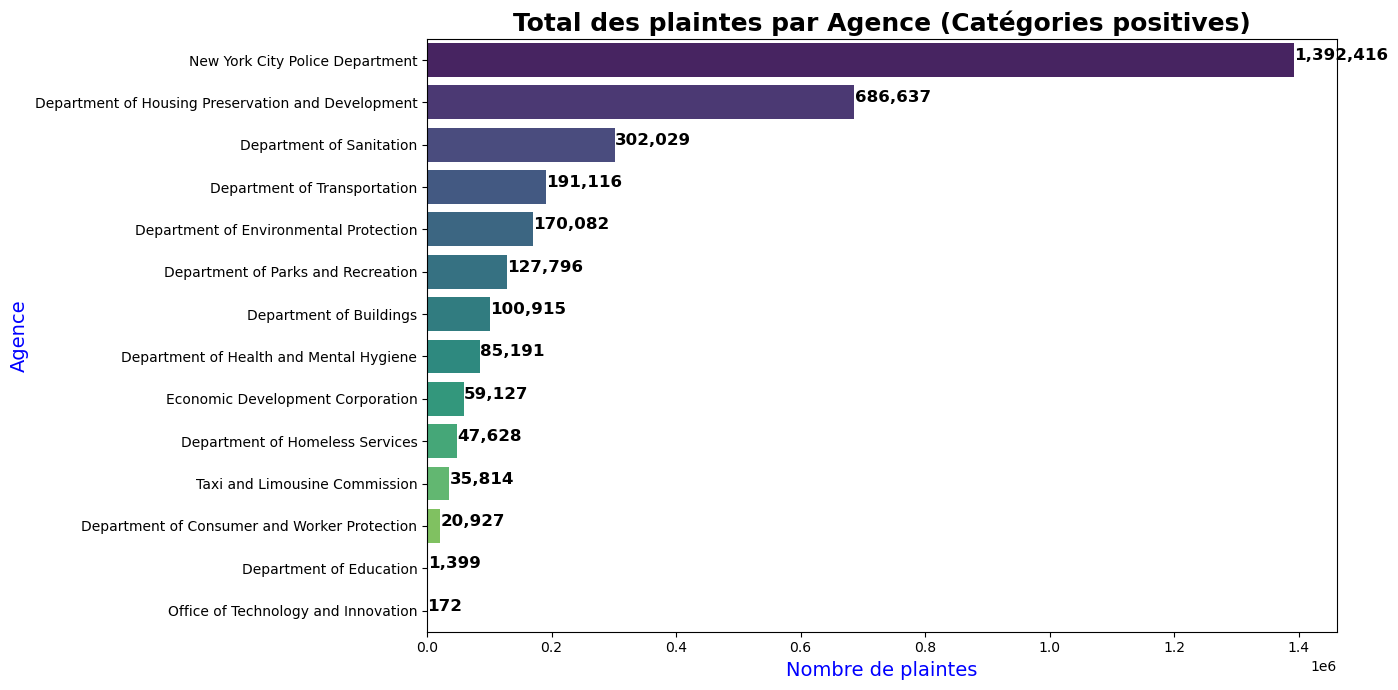

In [48]:
# Filtrer les plaintes pour les catégories spécifiées
filtered_complaints_selected = df[df['category_clcrea'].isin(['0-1m', '1m-10m', '10m-1h', '1h-24h', '24h-48h', '2j-7j', '7j+',  'null_closed_date'])]

# Calculer le total des plaintes par Agence dans les données filtrées
agency_name = filtered_complaints_selected['agency_name'].value_counts()

# Créer la figure
plt.figure(figsize=(14, 7))

# Générer le graphique avec la correction
ax = sns.barplot(
    x=agency_name.values,
    y=agency_name.index,
    hue=agency_name.index,  # Utiliser 'hue' pour ajouter des couleurs par agence
    dodge=False,  # Éviter le décalage des barres
    palette='viridis',
    legend=False  # Désactiver la légende
)

# Ajouter les valeurs au-dessus des barres
for index, value in enumerate(agency_name.values):
    plt.text(value + 500, index, f'{value:,}', ha='left', fontsize=12, fontweight='bold')

# Ajouter un titre et ajuster les labels
plt.title("Total des plaintes par Agence (Catégories positives)", fontsize=18, fontweight='bold')
plt.xlabel("Nombre de plaintes", fontsize=14, color="blue")
plt.ylabel("Agence", fontsize=14, color="blue")

# Optimiser l'affichage
plt.tight_layout()

# Afficher le graphique
plt.show()

# Conclusion : 📊 Les catégories positives sont alimentées par :

New York City Police Department	1,392,416	--> 43.1%

Department of Housing Preservation and Development	686,637	--> 21.3%

Department of Sanitation	302,029	--> 9.4%

Department of Transportation	191,116	--> 5.9%

Department of Environmental Protection	170,082	--> 5.3%

Department of Parks and Recreation	127,796	--> 3.95%

Department of Buildings	100,915	--> 3.1%

Department of Health and Mental Hygiene	85,191	--> 2.6%

Economic Development Corporation	59,127	--> 1.8%

Department of Homeless Services	47,628	--> 1.5%

Taxi and Limousine Commission	35,814	--> 1.1%

Department of Consumer and Worker Protection	20,927	--> 0.65%

Department of Education	1,399	--> 0.04%

Office of Technology and Innovation	172	--> 0.005%	


# 📊 Conclusion global 🌏🌟📣

# ✅ 64,84% plaintes sont resolues en 48h  🕑

Les délais les plus courts (0-1 minute et 1-10 minutes) concernent principalement des plaintes pouvant être automatiquement classées ou évaluées rapidement, tandis que les délais les plus longs (2 jours et plus) impliquent des interventions complexes nécessitant des inspections approfondies, des enquêtes ou des travaux correctifs.

1. Les délais courts 🔸

🤖 La plainte est automatiquement classée :
⮞ Cas déjà signalé → Certaines plaintes sont identifiées comme des doublons et immédiatement fusionnées avec des requêtes existantes.
⮞ Pas de violation constatée → Un grand nombre de plaintes liées aux nuisances sonores ou aux rongeurs (rats, souris, conditions favorisant leur présence) dominent largement le classement. Elles sont classées sans suite après une évaluation rapide via un processus automatisé de gestion.
⮞ Information immédiatement accessible → Certains signalements redirigent simplement vers un site officiel (ex. : statut d’un éclairage public sur le site du Department of Transportation).

🤠 La police peut évaluer rapidement la situation :
⮞ Le NYPD clôture de nombreuses plaintes de nuisances sonores et de stationnement illégal en quelques minutes, souvent après un passage rapide sur place.

Aucune intervention physique n’est nécessaire :
💬 Certains problèmes sont résolus par un message d’avertissement au propriétaire concerné, sans inspection immédiate (ex. : chiens sans laisse, problèmes mineurs de propreté).

✨ Agences concernées :
New York City Police Department (NYPD) → Bruits, stationnement illégal, nuisances mineures.
Department of Health and Mental Hygiene → Rongeurs, conditions sanitaires.
Department of Environmental Protection → Problèmes d’eau, signalements de fuites ou hydrants ouverts.

⚠️ Des résolutions ultra-rapides ne signifient pas nécessairement que le problème est réellement réglé, mais plutôt qu’un processus administratif ou une règle de filtrage a permis de clôturer la plainte rapidement. ⚠️

  2. Les délais longs 🔸

❗ Ces cas nécessitent une investigation, une inspection physique ou des travaux 🧐

🛠️ Réparations et interventions complexes :
⮞ Infrastructure urbaine (éclairage public, hydrants, parcs, collecte des déchets, état des routes, moisissures, parasites, insalubrité) → Ces interventions demandent du temps pour mobiliser les ressources et exécuter les travaux.
La gestion des accès aux logements, le suivi des évaluations et l’accompagnement d’experts ajoutent des défis logistiques importants.

💡 Problème récurrent : Certains dossiers sont classés sans violations, ce qui oblige à relancer la demande. En cas de résolution partielle, une nouvelle plainte peut être déposée, rallongeant ainsi la durée totale du traitement.

📜 Processus administratif et légal :
⮞ Véhicules abandonnés avec plaque → Vérification du propriétaire et éventuel remorquage.
⮞ Dossiers nécessitant une procédure juridique ou une mise en conformité (ex. : construction sans permis) → Le propriétaire doit être averti et dispose d’un délai pour corriger la situation avant toute sanction.

✨ Agences concernées :
Department of Buildings (DOB) → Travaux illégaux, inspections de structures.
Department of Housing Preservation and Development (HPD) → Logements insalubres, plaintes contre des propriétaires.
Department of Transportation (DOT) → Réparations de routes et infrastructures.
Department of Parks and Recreation → Entretien des parcs et espaces publics.
Department of Environmental Protection → Problèmes d’eau nécessitant des tests et des interventions techniques.

📌 L’efficacité des agences concernées, notamment le HPD, est mise à l’épreuve par ces plaintes récurrentes. Une meilleure coordination des interventions et un suivi plus rigoureux sont nécessaires.


si tu vois ce message

# ❌ Ne touche plus le code --> crée un copy 😅

message pour moi ^^ ⬆️ Iryna